# Problem Set 5: Optic Flow
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
# Imports
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.linalg import block_diag
from sklearn.cluster import KMeans
# Matplotlib params
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
## Hide axes in plots
show_axis = False
plt.rcParams['xtick.bottom'] = show_axis
plt.rcParams['xtick.labelbottom'] = show_axis
plt.rcParams['ytick.left'] = show_axis
plt.rcParams['ytick.labelleft'] = show_axis
plt.rcParams['axes.spines.left'] = show_axis
plt.rcParams['axes.spines.bottom'] = show_axis
plt.rcParams['axes.spines.top'] = show_axis
plt.rcParams['axes.spines.right'] = show_axis
## Axis labels
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelpad'] = 8

---
## 1. Gaussian and Laplacian Pyramids
### 1.1 Reduce

In [3]:
yos1 = cv2.imread('images/DataSeq1/yos_img_01.jpg', cv2.IMREAD_GRAYSCALE)
yos1 = yos1.astype(np.float) / 255

In [4]:
def reduce(img, level=1):
    # Reduction filter
    w = np.array([1, 4, 6, 4, 1]) / 16
    red = img
    for _ in range(level):
        # Apply filter and only take odd indices
        red = cv2.sepFilter2D(red, -1, w, w)[::2, ::2]
    return red

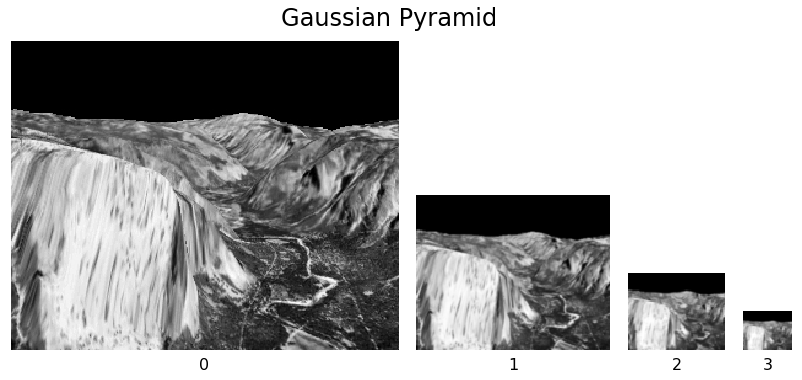

In [5]:
num_levels = 4
fig = plt.figure()
fig.suptitle('Gaussian Pyramid', y=0.72)
gs = gridspec.GridSpec(1, num_levels, width_ratios=[2**i for i in range(num_levels)][::-1], wspace=0.1)
g = yos1
for i in range(num_levels):
    ax = plt.subplot(gs[i])
    ax.imshow(g)
    ax.set_anchor('S')
    ax.set_xlabel(i, fontsize=16)
    g = reduce(g)

### 1.2 Expand

In [6]:
def expand(img, dstsize=None):
    '''
    ref: https://docs.opencv.org/2.4.13.7/doc/tutorials/imgproc/pyramids/pyramids.html
    '''
    # Expansion filter
    w = 2 * np.array([1, 4, 6, 4, 1]) / 16
    if dstsize is None:
        # Double size
        expd = np.zeros((2*img.shape[0], 2*img.shape[1]))
    else:
        # Use given size
        expd = np.zeros(dstsize)
    # Odd indices
    expd[::2, ::2] = img
    # Apply filter
    expd = cv2.sepFilter2D(expd, -1, w, w)
    return expd

In [7]:
num_levels = 4
fig = plt.figure()
fig.suptitle('Laplacian Pyramid', y=0.72)
gs = gridspec.GridSpec(1, num_levels, width_ratios=[2**i for i in range(num_levels)][::-1], wspace=0.1)
g = yos1
for i in range(num_levels-1):
    l = g - expand(reduce(g), dstsize=g.shape)
    ax = plt.subplot(gs[i])
    ax.imshow(l)
    ax.set_anchor('S')
    ax.set_xlabel(i, fontsize=16)
    g = reduce(g)
ax = plt.subplot(gs[-1])
ax.imshow(g)
ax.set_anchor('S')
ax.set_xlabel('G', fontsize=16);

---
## 2. Lucas Kanade optic flow

In [466]:
img1_u8 = cv2.imread('images/TestSeq/Shift0.png', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255

In [467]:
def gradX(img):
    '''
    Calculate horizontal image gradient.
    '''
    # Horizonal Sobel
    grad_img = cv2.Sobel(img, -1, 1, 0,ksize=1)
    return grad_img
    
def gradY(img):
    '''
    Calculate vertical image gradient.
    '''
    # Vertical Sobel
    grad_img = cv2.Sobel(img, -1, 0, 1,ksize=1)
    return grad_img

### 2.1 Small Displacements

In [468]:
def plot_flow_quiver(ax, img, u, v, resolution=5):
    ax.imshow(img)
    m, n = img.shape
    yv, xv = np.mgrid[:m:resolution, :n:resolution]
    u_ = u[yv, xv]
    # Positive v corresponds to movement in negative y
    v_ = -v[yv, xv]
    ax.quiver(xv, yv, u_, v_, color='r')
    return

def plot_flow_dense(ax1, ax2, u, v):
    flowmin = min(u.min(), v.min())
    flowmax = max(u.max(), v.max())
    ## Horizontal
    im1 = ax1.imshow(u, vmin=flowmin, vmax=flowmax)
    ax1.set_title('Horizontal flow (u)')
    ax1.axis('off')
    ## Vertical
    im2 = ax2.imshow(v, vmin=flowmin, vmax=flowmax)
    ax2.set_title('Vertical flow (v)')
    ax2.axis('off')
    return

def plot_flow(img, u, v, resolution=5):
    fig = plt.figure(figsize=(14, 7), constrained_layout=True)
    gs = fig.add_gridspec(2, 2, width_ratios=[2,1])
    ax1 = fig.add_subplot(gs[:, 0])
    plot_flow_quiver(ax1, img, u, v, resolution)
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    plot_flow_dense(ax2, ax3, u, v)
    return


In [469]:
def lk_iter(img1, img2, blursize=1, window_size=3):
    # Blur
    img1 = cv2.GaussianBlur(img1, (blursize, blursize), 0)
    img2 = cv2.GaussianBlur(img2, (blursize, blursize), 0)
    # Gradients
    Ix = gradX(img1)
    Iy = gradY(img1)
    # Time derivative
    It = img2 - img1
    # 2nd Order Moments
    IxIx = cv2.boxFilter(Ix*Ix, -1, ksize=(window_size, window_size), normalize=True)
    IxIy = cv2.boxFilter(Ix*Iy, -1, ksize=(window_size, window_size), normalize=True)
    IyIy = cv2.boxFilter(Iy*Iy, -1, ksize=(window_size, window_size), normalize=True)
    IxIt = cv2.boxFilter(Ix*It, -1, ksize=(window_size, window_size), normalize=True)
    IyIt = cv2.boxFilter(Iy*It, -1, ksize=(window_size, window_size), normalize=True)
    # Initialize outputs
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    for y, x in np.ndindex(img1.shape):
        A = np.array([[IxIx[y,x], IxIy[y,x]],
                      [IxIy[y,x], IyIy[y,x]]])
        b = np.array([-IxIt[y,x], -IyIt[y,x]])
        if np.linalg.matrix_rank(A, tol=1e-6) == 2:
            u[y,x], v[y,x] = np.linalg.solve(A, b)
    return u, v

#### a. ShiftR2

In [470]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR2.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

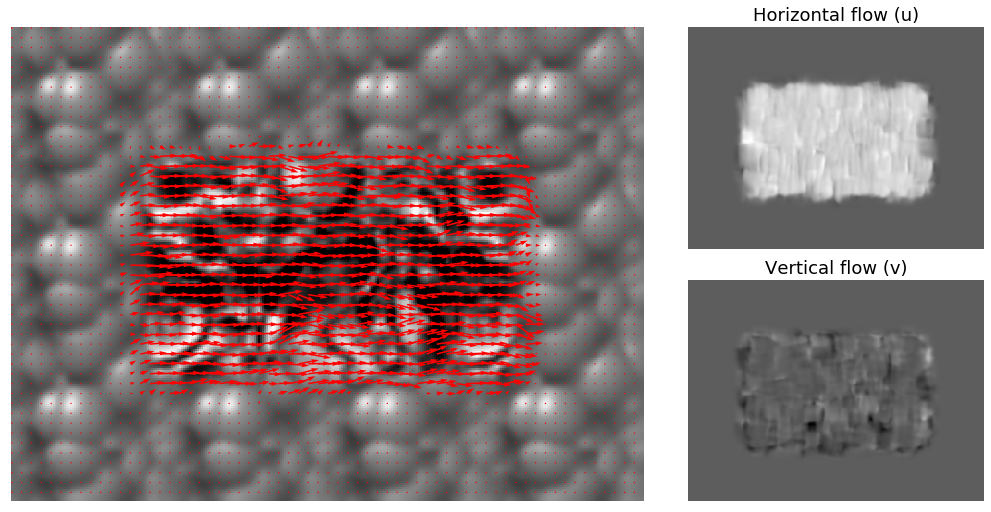

In [474]:
u, v = lk_iter(img1, img2, blursize=11, window_size=15)
plot_flow(img1, u, v)

#### b. ShiftR5U5

In [237]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR5U5.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

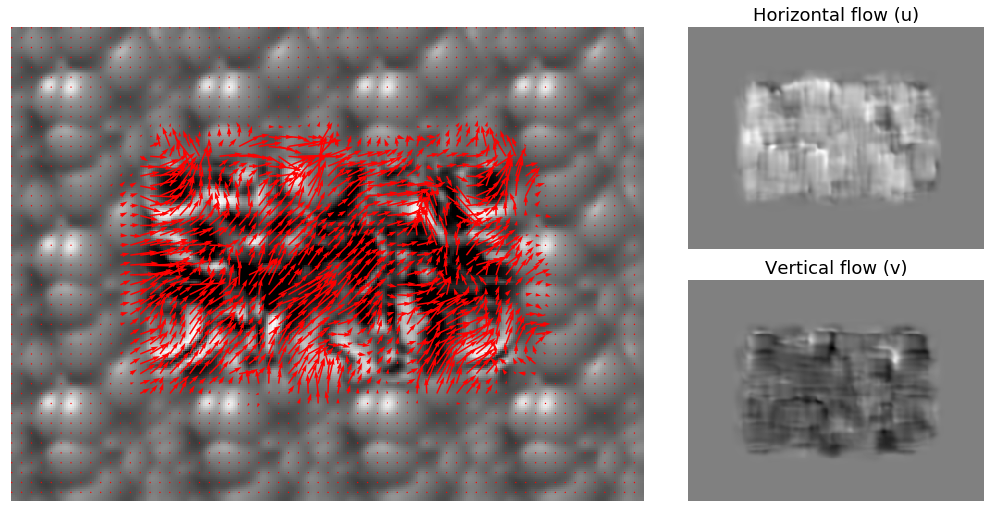

In [238]:
u, v = lk_iter(img1, img2, blursize=11, window_size=21)
plot_flow(img1, u, v)

### 2.2 Large Displacements

#### a. ShiftR10

In [16]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR10.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

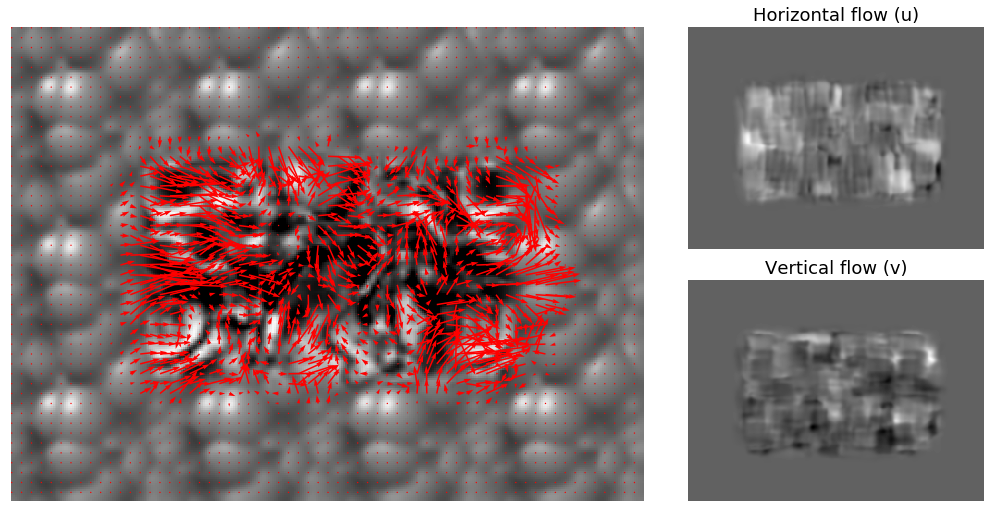

In [17]:
u, v = lk_iter(img1, img2, blursize=11, window_size=21)
plot_flow(img1, u, v)

#### b. ShiftR20

In [18]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR20.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

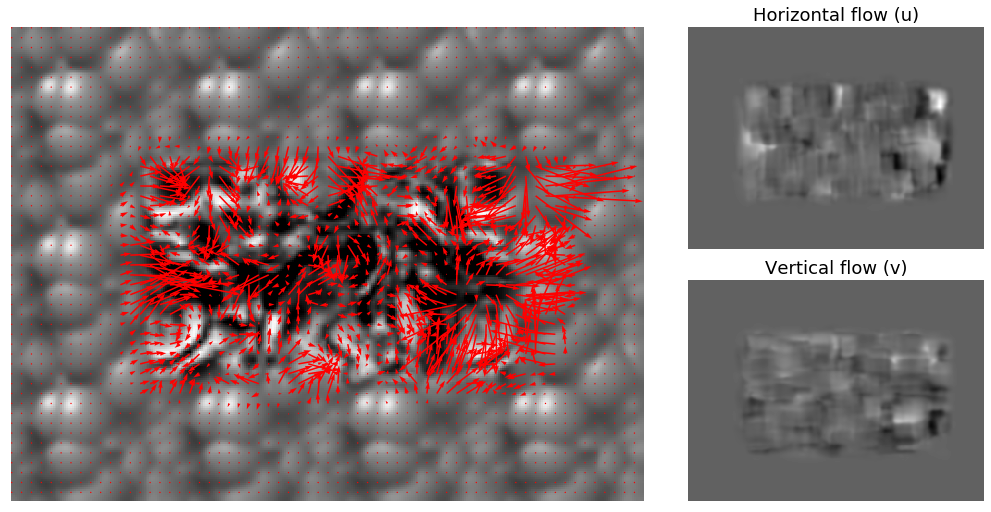

In [19]:
u, v = lk_iter(img1, img2, blursize=11, window_size=21)
plot_flow(img1, u, v)

#### c. ShiftR40

In [20]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR40.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

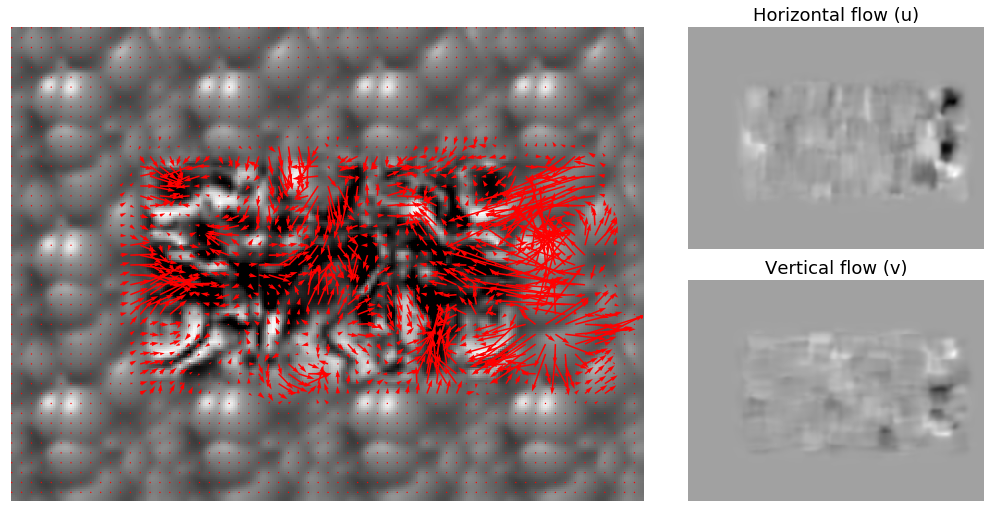

In [21]:
u, v = lk_iter(img1, img2, blursize=11, window_size=21)
plot_flow(img1, u, v)

### 2.3 Warping

In [22]:
def warp(img, u, v):
    h, w = img.shape
    mapx = -u + np.arange(w)
    mapy = -v + np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, mapx.astype(np.float32), mapy.astype(np.float32), interpolation=cv2.INTER_LINEAR)
    return res

#### a. DataSeq1

In [23]:
img1_u8 = cv2.imread('images/DataSeq1/yos_img_01.jpg', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255
img2_u8 = cv2.imread('images/DataSeq1/yos_img_02.jpg', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

In [24]:
img1r = reduce(img1, level=2)
img2r = reduce(img2, level=2)

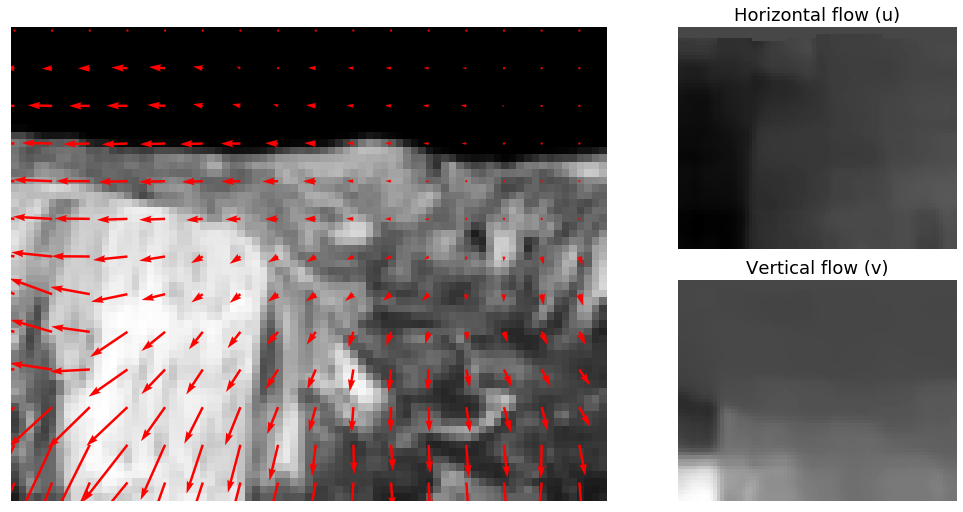

In [25]:
u, v = lk_iter(img1r, img2r, blursize=11, window_size=21)
plot_flow(img1r, u, v)

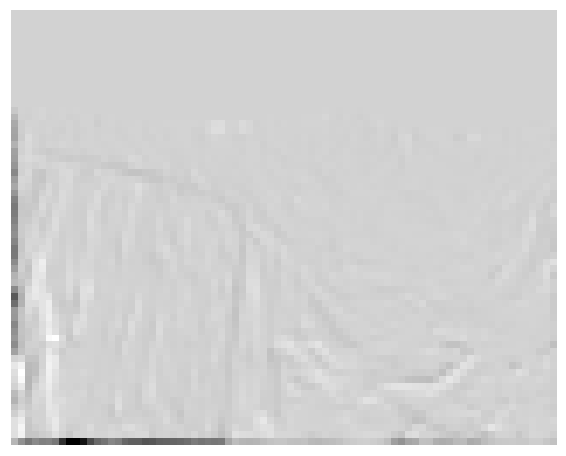

In [26]:
img2r_warped = warp(img2r, -u, -v)
plt.imshow(img2r_warped - img1r)
cv2.imwrite('images/DataSeq1/1.jpg', 255*img1r);
cv2.imwrite('images/DataSeq1/1w.jpg', 255*img2r_warped);

In [27]:
img3_u8 = cv2.imread('images/DataSeq1/yos_img_03.jpg', cv2.IMREAD_GRAYSCALE)
img3 = img3_u8.astype(np.float) / 255

In [28]:
img3r = reduce(img3, level=2)

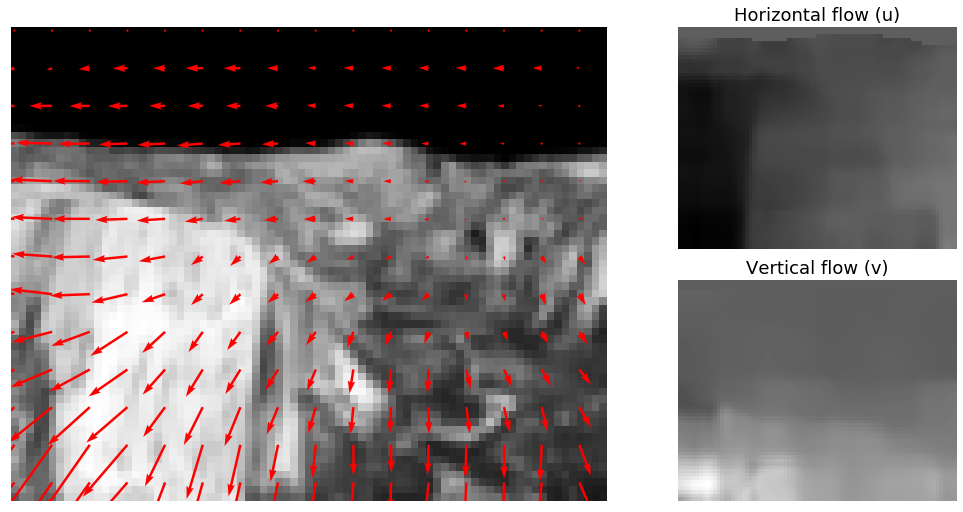

In [29]:
u, v = lk_iter(img2r, img3r, blursize=11, window_size=21)
plot_flow(img2r, u, v)

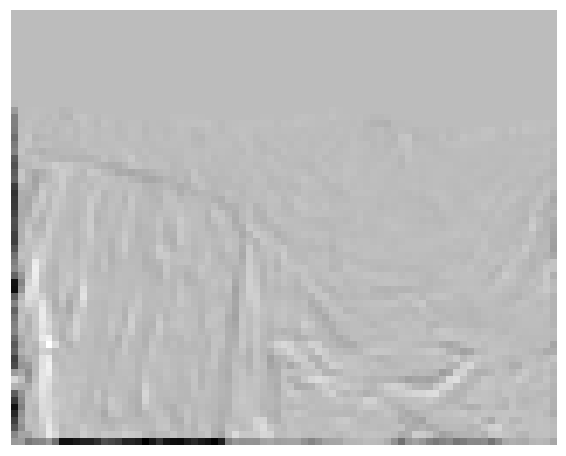

In [30]:
img3r_warped = warp(img3r, -u, -v)
plt.imshow(img3r_warped - img2r)
cv2.imwrite('images/DataSeq1/2.jpg', 255*img2r);
cv2.imwrite('images/DataSeq1/2w.jpg', 255*img3r_warped);

#### b. DataSeq2

In [31]:
img1_u8 = cv2.imread('images/DataSeq2/0.png', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255
img2_u8 = cv2.imread('images/DataSeq2/1.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

In [32]:
img1r = reduce(img1, level=3)
img2r = reduce(img2, level=3)

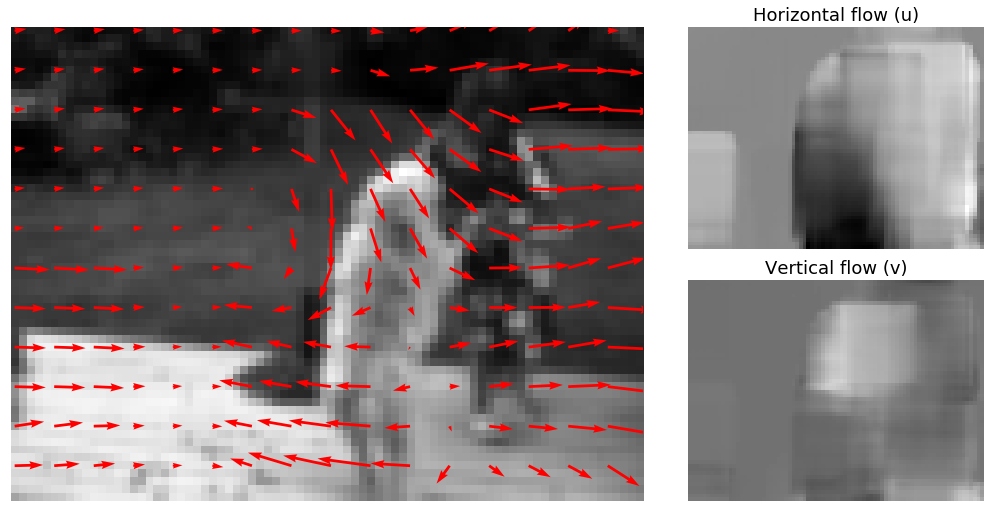

In [33]:
u, v = lk_iter(img1r, img2r, blursize=1, window_size=21)
plot_flow(img1r, u, v)

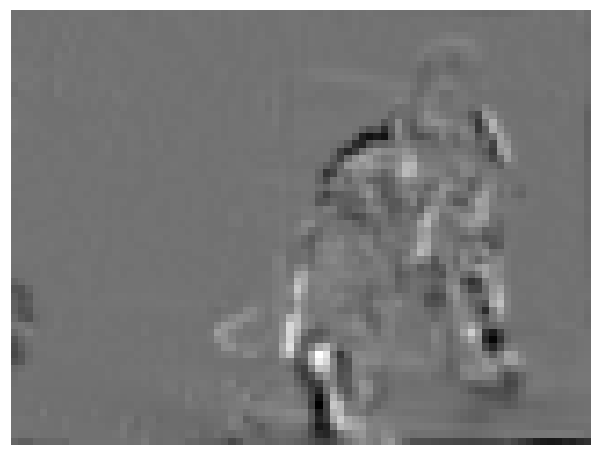

In [34]:
img2r_warped = warp(img2r, -u, -v)
plt.imshow(img2r_warped - img1r)
cv2.imwrite('images/DataSeq2/0r.png', 255*img1r);
cv2.imwrite('images/DataSeq2/0w.png', 255*img2r_warped);

In [35]:
img3_u8 = cv2.imread('images/DataSeq2/2.png', cv2.IMREAD_GRAYSCALE)
img3 = img3_u8.astype(np.float) / 255

In [36]:
img3r = reduce(img3, level=3)

In [37]:
u, v = lk_iter(img2r, img3r, blursize=11, window_size=21)
plot_flow(img2r, u, v)

In [38]:
img3r_warped = warp(img3r, -u, -v)
plt.imshow(img3r_warped - img2r)
cv2.imwrite('images/DataSeq2/1r.png', 255*img2r);
cv2.imwrite('images/DataSeq2/1w.png', 255*img3r_warped);

---
## 3. Hierarchical LK optic flow

In [567]:
def heirarchical_lk(img1, img2, blursize=1, window_size=3, levels=1):
    for i in range(levels+1):
        k = levels - i
        Lk = reduce(img1, k)
        Rk = reduce(img2, k)
        if k == levels:
            u = np.zeros_like(Lk)
            v = np.zeros_like(Lk)
        else:
            u = 2*expand(u, dstsize=Lk.shape)
            v = 2*expand(v, dstsize=Lk.shape)
        Wk = warp(Lk, u, v)
        Dx, Dy = lk_iter(Wk, Rk, blursize, window_size)
        u += Dx
        v += Dy
    return u, v

#### a. TestSeq

In [568]:
img1_u8 = cv2.imread('images/TestSeq/Shift0.png', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255

##### i. ShiftR10

In [569]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR10.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

In [570]:
u, v = heirarchical_lk(img1, img2, blursize=5, window_size=15, levels=4)
plot_flow(img1, u, v)

##### ii. ShiftR20

In [43]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR20.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

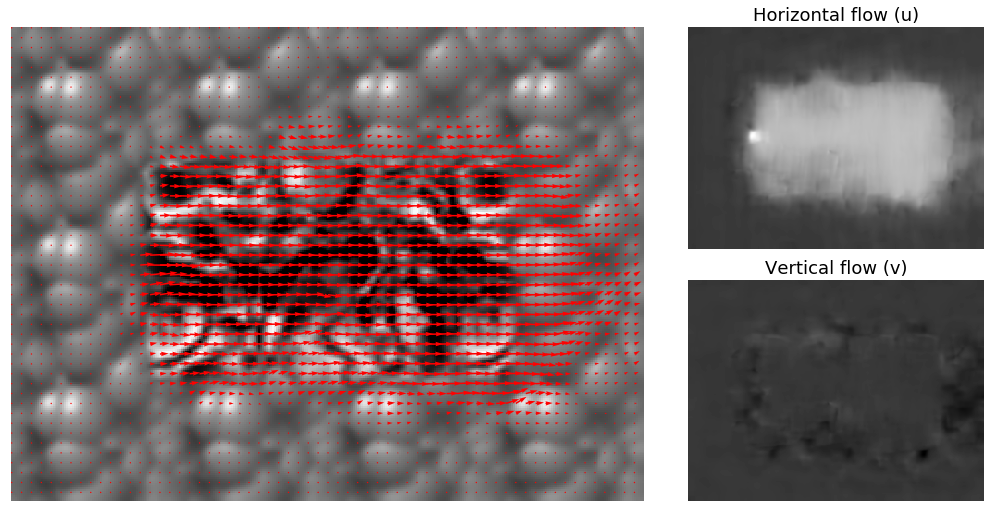

In [44]:
u, v = heirarchical_lk(img1, img2, blursize=5, window_size=15, levels=4)
plot_flow(img1, u, v)

##### iii. ShiftR40

In [45]:
img2_u8 = cv2.imread('images/TestSeq/ShiftR40.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

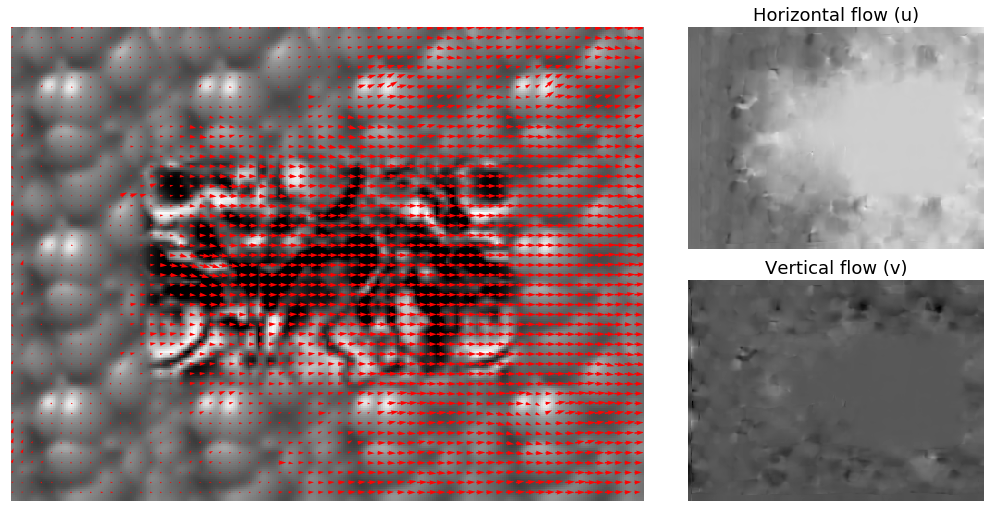

In [46]:
u, v = heirarchical_lk(img1, img2, blursize=1, window_size=9, levels=6)
plot_flow(img1, u, v)

#### b. DataSeq1

In [401]:
img1_u8 = cv2.imread('images/DataSeq1/yos_img_01.jpg', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255
img2_u8 = cv2.imread('images/DataSeq1/yos_img_02.jpg', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

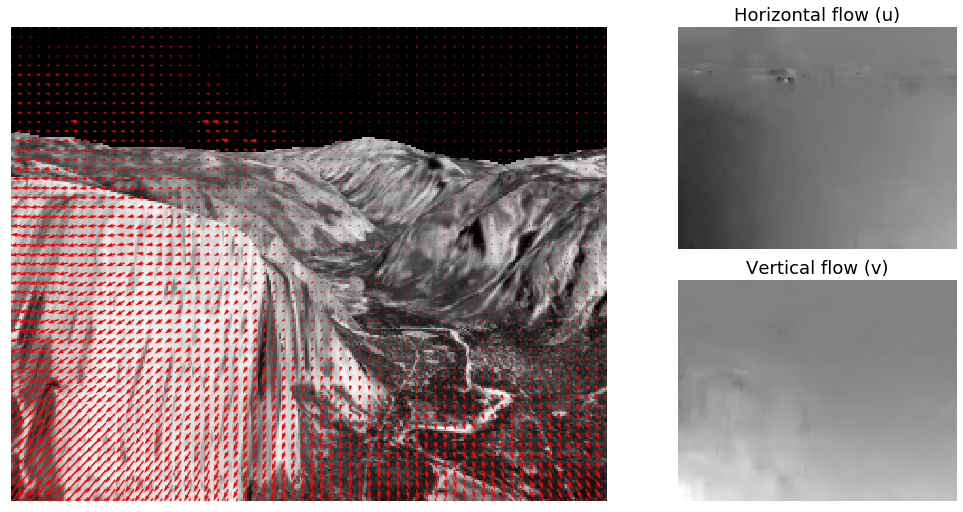

In [402]:
u, v = heirarchical_lk(img1, img2, blursize=5, window_size=15, levels=3)
plot_flow(img1, u, v)

In [49]:
img3_u8 = cv2.imread('images/DataSeq1/yos_img_03.jpg', cv2.IMREAD_GRAYSCALE)
img3 = img3_u8.astype(np.float) / 255

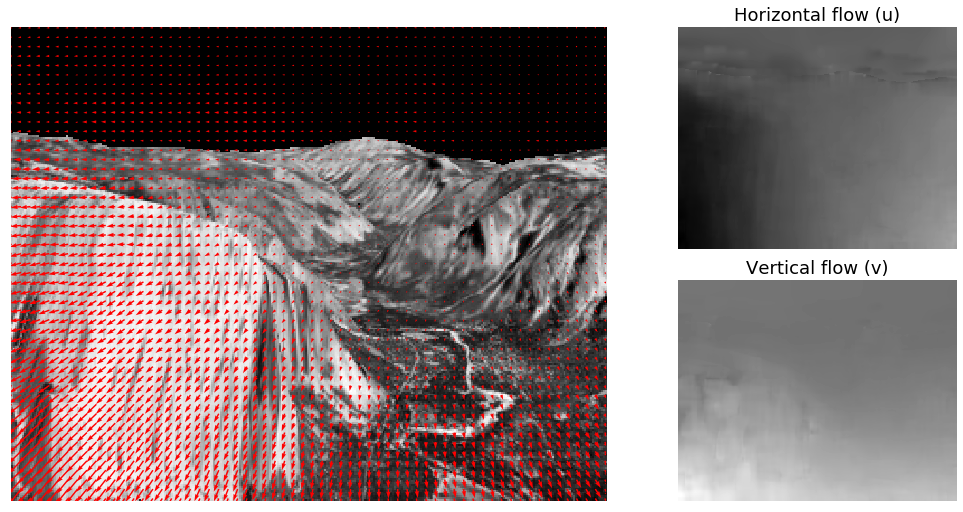

In [50]:
u, v = heirarchical_lk(img2, img3, blursize=5, window_size=15, levels=4)
plot_flow(img2, u, v)

#### b. DataSeq2

In [462]:
img1_u8 = cv2.imread('images/DataSeq2/0.png', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255
img2_u8 = cv2.imread('images/DataSeq2/1.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

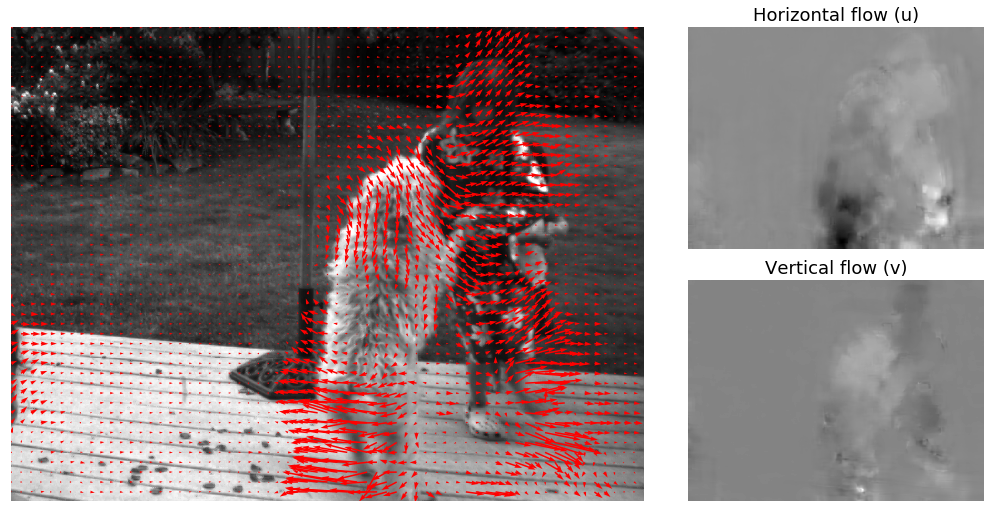

In [463]:
u, v = heirarchical_lk(img1, img2, blursize=5, window_size=15, levels=4)
plot_flow(img1, u, v, resolution=10)

In [53]:
img3_u8 = cv2.imread('images/DataSeq2/2.png', cv2.IMREAD_GRAYSCALE)
img3 = img3_u8.astype(np.float) / 255

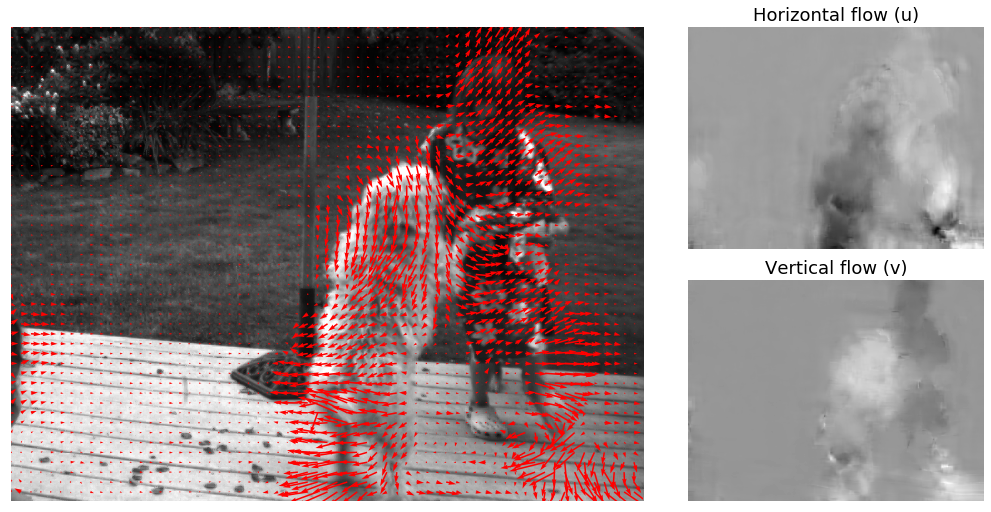

In [54]:
u, v = heirarchical_lk(img2, img3, blursize=5, window_size=15, levels=4)
plot_flow(img2, u, v, resolution=10)

---
## 4. The Juggle Sequence

In [55]:
img1_u8 = cv2.imread('images/Juggle/0.png', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255
img2_u8 = cv2.imread('images/Juggle/1.png', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

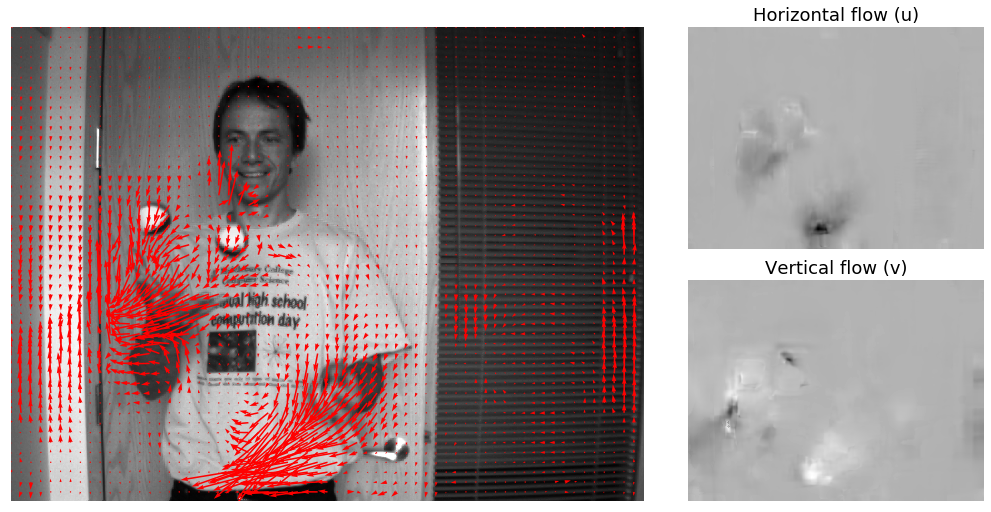

In [56]:
u, v = heirarchical_lk(img1, img2, blursize=11, window_size=21, levels=5)
plot_flow(img1, u, v, resolution=10)

In [57]:
img3_u8 = cv2.imread('images/Juggle/2.png', cv2.IMREAD_GRAYSCALE)
img3 = img3_u8.astype(np.float) / 255

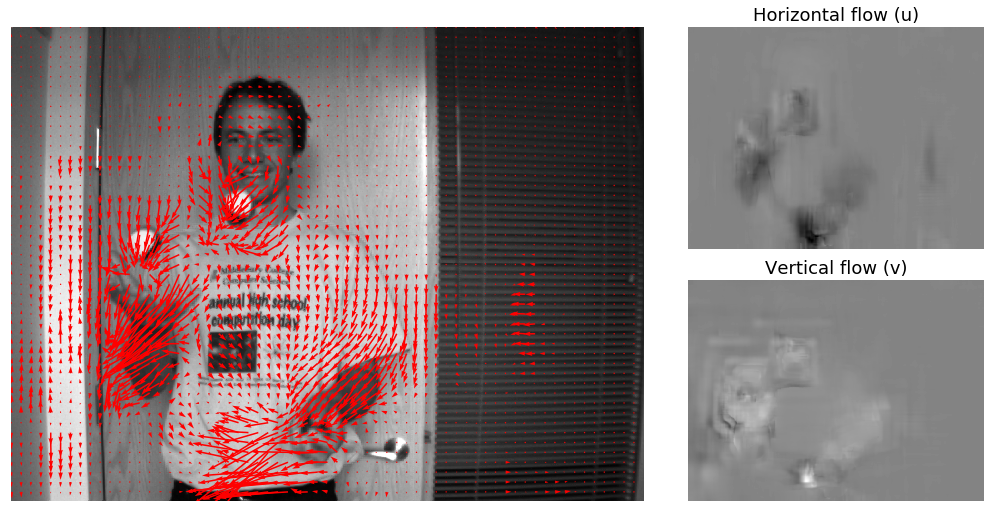

In [58]:
u, v = heirarchical_lk(img2, img3, blursize=1, window_size=21, levels=4)
plot_flow(img2, u, v, resolution=10)

---
## 5. The Taxi Sequence

In [523]:
img1_u8 = cv2.imread('images/Taxis/taxi-00.tif', cv2.IMREAD_GRAYSCALE)
img1 = img1_u8.astype(np.float) / 255
img2_u8 = cv2.imread('images/Taxis/taxi-01.tif', cv2.IMREAD_GRAYSCALE)
img2 = img2_u8.astype(np.float) / 255

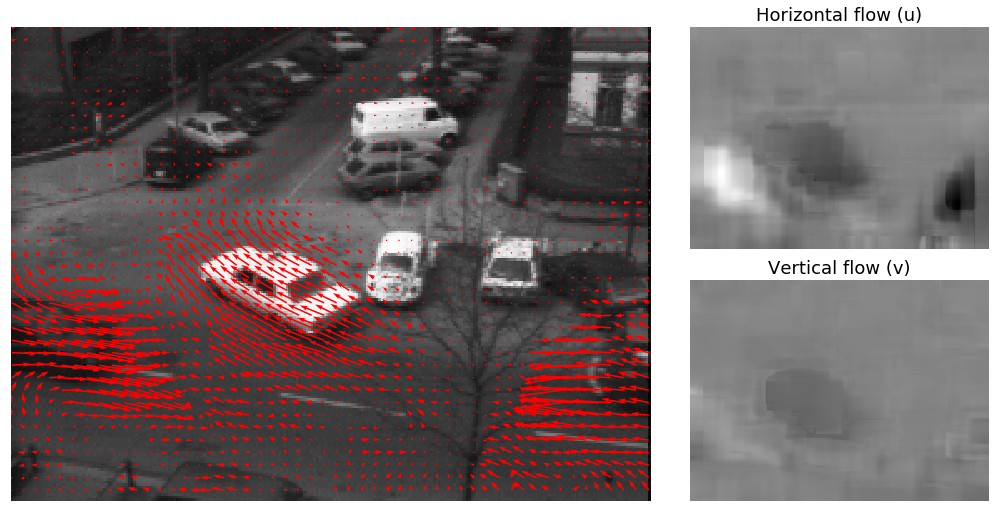

In [524]:
u, v = heirarchical_lk(img1, img2, window_size=21, levels=6)
plot_flow(img1, u, v)

In [565]:
def fit_affine_motion(u, v, block_size=16, thresh=1e-3):
    h, w = u.shape
    y, x = np.mgrid[:h, :w]
    a = np.zeros((1,6))
    for j in range(0, h, block_size):
        for i in range(0, w, block_size):
            ub = u[j:j+block_size, i:i+block_size].flatten()
            vb = v[j:j+block_size, i:i+block_size].flatten()
            xb = x[j:j+block_size, i:i+block_size].flatten()
            yb = y[j:j+block_size, i:i+block_size].flatten()
            nelems = ub.size
            Ad = np.stack((xb, yb, np.ones(nelems)), axis=-1)
            A = block_diag(Ad, Ad)
            b = np.hstack((ub, vb))
            if np.any(b > 1e-1):
                aij, resd = np.linalg.lstsq(A, b, rcond=None)[:2]
                resdavg = resd.item() / nelems
                if resdavg < thresh:
                    a = np.vstack((a, aij))
    return a

def segment(u, v, motions):
    h, w = u.shape
    resd = np.zeros((h, w, len(motions)))
    for ix, a in enumerate(motions):
        y, x = np.mgrid[:h, :w]
        a1, a2, a3, a4, a5, a6 = a
        u_ = a1*x + a2*y + a3
        v_ = a4*x + a5*y + a6
        resd[:, :, ix] = (u-u_)**2 + (v-v_)**2
    segm = resd.argmin(-1)
    resdmin = resd.min(-1)
    segm[resdmin>1e-1] = -1
    return segm

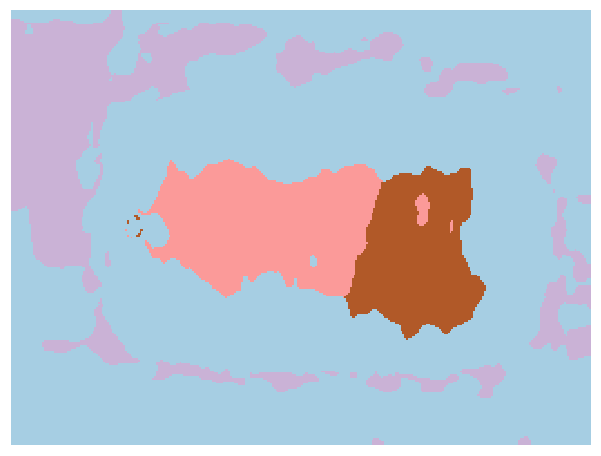

In [571]:
motions = fit_affine_motion(u,v)
# Cluster candidates
kmeans = KMeans(n_clusters=3).fit(motions)
motions = kmeans.cluster_centers_
# Segment Image
imgsemg = segment(u, v, motions)
cmap = plt.get_cmap('Paired', np.max(imgsemg)-np.min(imgsemg)+1)
plt.imshow(imgsemg, cmap=cmap)

---
# ROUGH

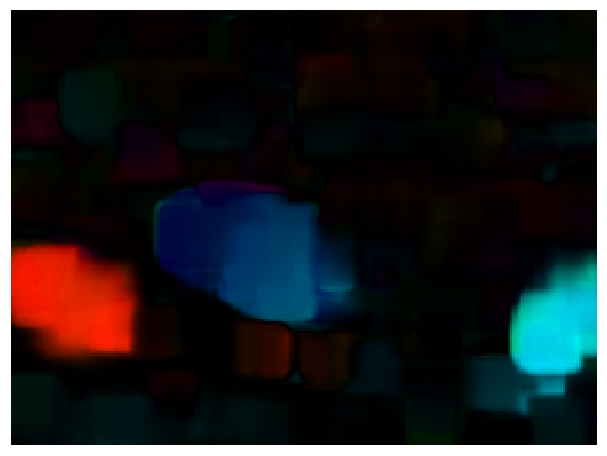

In [525]:
hsv = np.zeros(img1_u8.shape + (3,))
hsv[...,1] = 255

flow = cv2.calcOpticalFlowFarneback(img1_u8, img2_u8, None, 0.5, 3, 21, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
hsv = hsv.astype('uint8')
rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
plt.imshow(rgb)

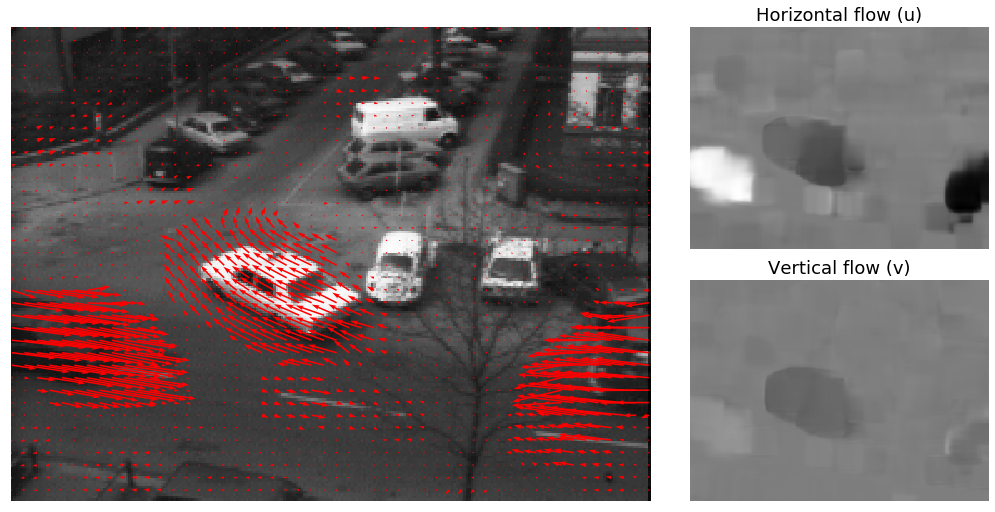

In [526]:
u, v = flow[:, :, 0], flow[:, :, 1]
plot_flow(img1, u, v, resolution=5)

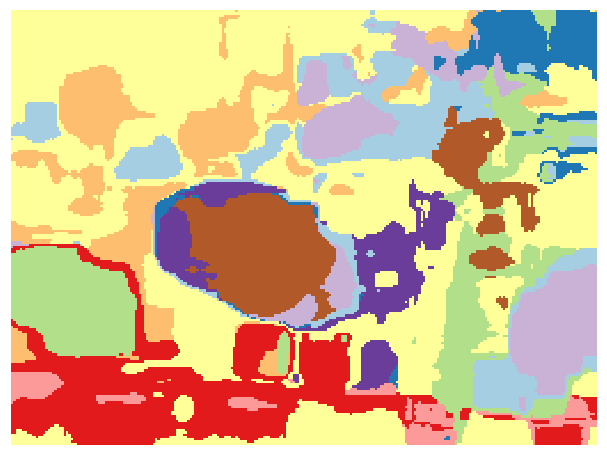

In [531]:
motions = fit_affine_motion(u,v)
# Cluster candidates
kmeans = KMeans(n_clusters=10, random_state=0).fit(motions)
motions = kmeans.cluster_centers_
# Segment Image
imgsemg = segment(u, v, motions)
cmap = plt.get_cmap('Paired', np.max(imgsemg)-np.min(imgsemg)+1)
plt.imshow(imgsemg, cmap=cmap)

True

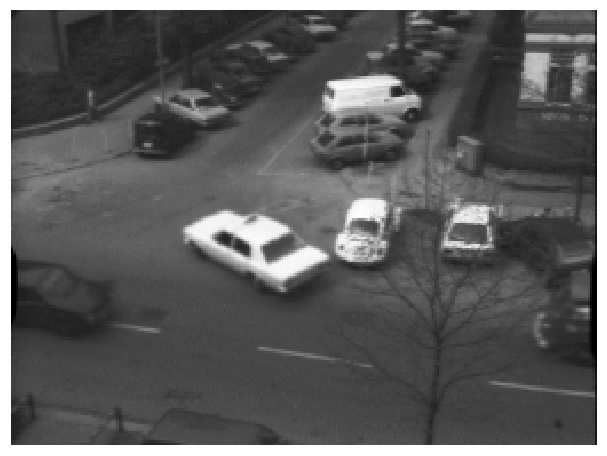

In [392]:
img1_warped = warp(img1, u, v)
plt.imshow(img1_warped)
# cv2.imwrite('images/TestSeq/Shift0w.png', 255*img1_warped)